# Tutorial 2: SSALib Plotting Guide

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/ssalib/blob/main/notebooks/02_ssa_plotting_guide.ipynb)

This tutorial covers the available visualizations in SSALib, illustrated using Sea Surface Temperature (SST) data.


**Quick link**
_Works in Jupyter_

* [`kind='matrix'`](#Matrix-Plot)
* [`kind='paired'`](#Paired-Plot)
* [`kind='periodogram'`](#Periodogram-Plot)
* [`kind='timeseries'`](#Timeseries-Plot)
* [`kind='values'`](#Value-Plot)
* [`kind='vectors'`](#Vector-Plot)
* [`kind='wcorr'`](#Weighted-Correlation-Plot)

In [1]:
#!pip install ssalib # Uncomment to install ssalib
import matplotlib.pyplot as plt
from ssalib import SingularSpectrumAnalysis as SSA
from ssalib.datasets import load_sst

#help(SingularSpectrumAnalysis.plot)  # Uncomment to get help

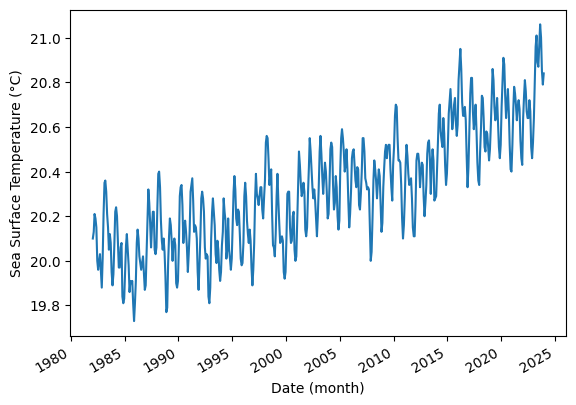

In [2]:
#help(load_sst)  # Uncomment to get help
sst = load_sst()  # Sea Surface Temperature Data
ax = sst.plot()
_ = ax.set_xlabel('Date (month)')
_ = ax.set_ylabel('Sea Surface Temperature (°C)')

## Overview

* The `SingularSpectrumAnalysis.plot` method can be used to access all kinds of plots.
* Some plot kinds, or some kind-specific features, depends on the SSA stage (i.e, initialized, decomposed, or reconstructed).
* All available kinds can be accessed by calling the method `SingularSpectrumAnalysis.available_plots()`

In [3]:
SSA.available_plots()

['matrix', 'paired', 'periodogram', 'timeseries', 'values', 'vectors', 'wcorr']

## Plot Kinds

### Matrix Plot

_Decomposition optional_

Matrix plot (`kind='matrix'`) enables plotting the SVD matrix being decomposed, or its reconstruction based on a selection of indices. The matrix plot is mostly meant for an educative and development purpose.

**Kind-Specific Arguments**
- `indices`: list of indices for matrix reconstruction. If None (default), the original matrix is shown.

**Extra Arguments**

- See [`matplotlib.pyplot.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)

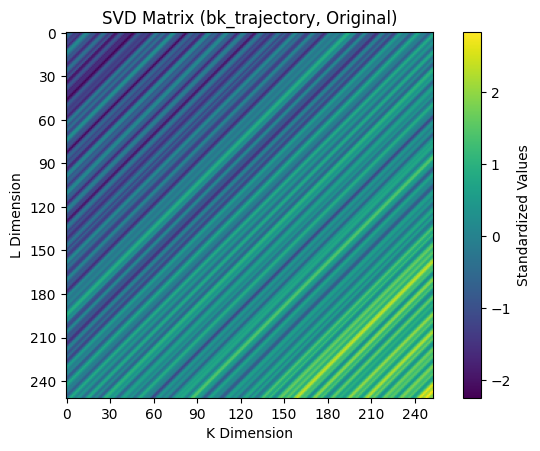

In [4]:
ssa_bk = SSA(sst)  # svd_matrix_kind is 'bk_trajectory' by default
fig, ax = ssa_bk.plot(kind='matrix')
ax.set_xlabel('K Dimension')
ax.set_ylabel('L Dimension')
ax.images[0].colorbar.set_label('Standardized Values')

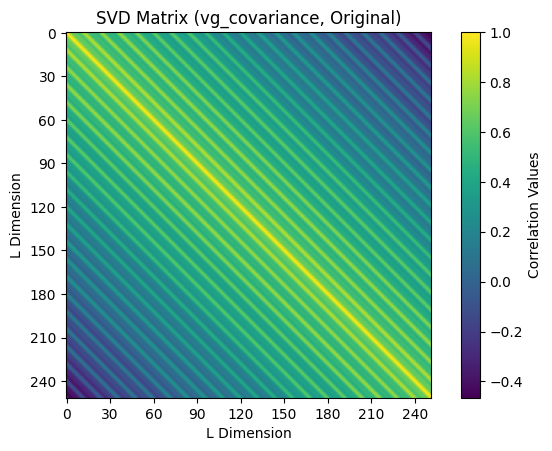

In [5]:
ssa_vg = SSA(sst, svd_matrix_kind='vg_covariance')
fig, ax = ssa_vg.plot(kind='matrix')
ax.set_xlabel('L Dimension')
ax.set_ylabel('L Dimension')
ax.images[0].colorbar.set_label('Correlation Values')

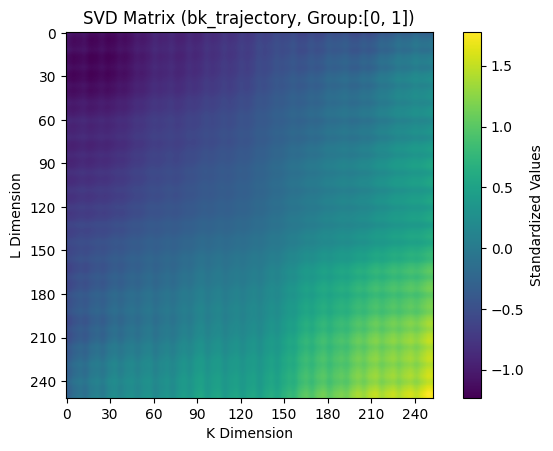

In [6]:
ssa_bk.decompose()
fig, ax = ssa_bk.plot(kind='matrix', indices=[0, 1])
ax.set_xlabel('K Dimension')
ax.set_ylabel('L Dimension')
ax.images[0].colorbar.set_label('Standardized Values')

### Paired Plot

_Decomposition required._

Paired plot (`kind='paired'`) is a collection of subplots illustrating patterns for successive pairs of eigenvectors.
Paired plot is used for structured pattern recognition and to hint on the frequency of the reconstructed patterns.
This visualization is inspired from the rSSA package in R [[1]](#ref-1).

The title mentions the percentage contribution of the components in capturing the variance of the SVD matrix.

**Kind-Specific Arguments**
- n_components: the maximum number of components to include. Default is 10.

**Extra Arguments**

- See [`matplotlib.pyplot.plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)

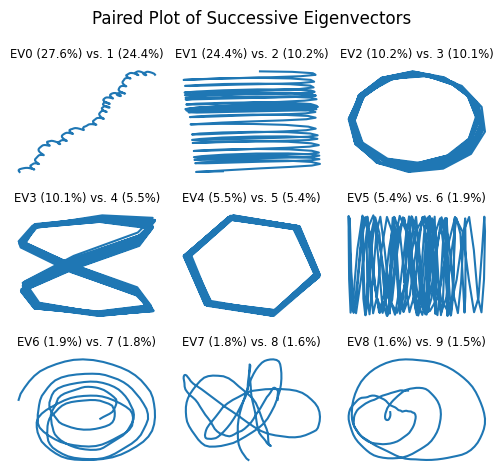

In [7]:
ssa = SSA(sst).decompose()
fig, axes = ssa.plot(kind='paired')
fig.suptitle('Paired Plot of Successive Eigenvectors')
fig.tight_layout()

**Remarks**
* Pairs of eigenvectors EV0 and 1 highlight a mostly non-repetitive pattern corresponding to a trend, capturing 50% of the variance.
* EV2 and 3 highlight a dodecagon, corresponding the annual cycle (since `sst` is monthly) that captures more than 20% of the variance.
* EV4 and 6 highlight a hexagon, corresponding the semi-annual cycle, capturing more than 10% of the variance.


### Periodogram Plot

_Decomposition required._

Periodogram plot (`kind='periodogram'`) is a collection of subplots illustrating the power spectral density associated with each component, with the power spectral density of the original signal shown in the background. Periodograms are computed using
the [`scipy.signal.periodogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html) method.

The title mentions the period corresponding to the dominant frequency associated with the component (`T`).

**Kind-Specific Arguments**
- n_components: the maximum number of components to include. Default is 10.
- scale: whether to use a 'plot', 'loglog' (default), 'semilogx', or 'semilogy' plot for scaling.

**Extra Arguments**

- See [`matplotlib.pyplot.plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)
- See [`matplotlib.pyplot.loglog`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.loglog.html)
- See [`matplotlib.pyplot.semilogx`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogx.html)
- See [`matplotlib.pyplot.semilogy`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogy.html)

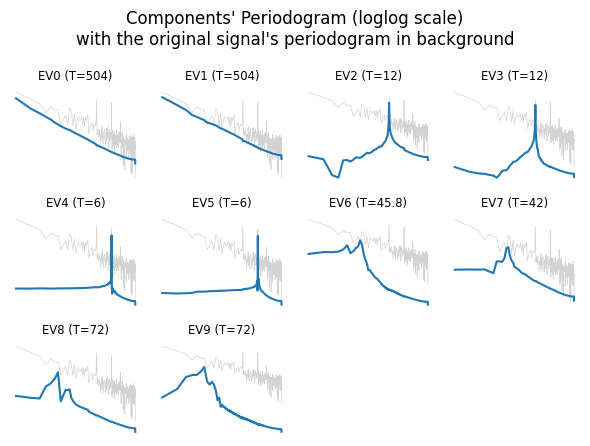

In [8]:
ssa = SSA(sst).decompose()
fig, axes = ssa.plot(kind='periodogram', scale='loglog')
fig.suptitle('Components\' Periodogram (loglog scale)\nwith the original signal\'s periodogram in background')
fig.tight_layout()

**Remarks**
- Trend components EV0 and EV1 show a clean slope in the loglog scale; the dominant period is in this case returned as the length of the timeseries;
- The annual cycle (EV2, EV3) and semi-annual cycle (EV4, EV5) are clearly identifiable.

**Note**

The frequencies and the power spectral density of the original timeseries can be accessed with the `SingularSpectrumAnalyisis.periodogram` attribute.

Text(0, 0.5, 'Power Spectral Density')

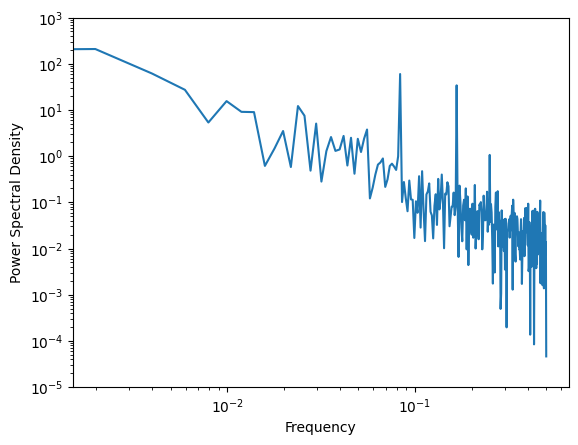

In [9]:
freq, psd = ssa.periodogram
fig, ax = plt.subplots()
ax.loglog(freq, psd)
ax.set_ylim(1e-5, 1e3)
ax.set_xlabel('Frequency')
ax.set_ylabel('Power Spectral Density')

The dominant frequencies for a desired number of components can be accessed with the `SingularSpectrumAnalysis.get_dominant_frequencies` method.

In [10]:
dominant_frequencies = ssa.get_dominant_frequencies(n_components=6)
dominant_periods = 1/dominant_frequencies
dominant_periods

array([504., 504.,  12.,  12.,   6.,   6.])

### Timeseries Plot

_Decomposition optional_, _Reconstruction optional_

Plot timeseries related to the ssa decomposition, including:
- `ssa_original`: the time series passed to the `SingularSpectrumAnalysis` object.
- `ssa_preprocessed`: the preprocessed time series turned into an SVD matrix for decomposition.
- `ssa_reconstructed`: the reconstructed time series based on all components resulting for the SVD. Should be equal to `ssa_preprocessed` for non-truncated SVD. Decomposition is required.
- user-defined names: time series reconstructed using the `SingularSpectrumAnalysis.reconstruct` method with user-defined `groups`.
- `ssa_residuals`: `ssa_preprocessed` minus the signal reconstruction from all unique user-selected component indices.

**Kind-Specific Arguments**
- include: list of timeseries names to include in the time series plot. If None and 'exclude' is None, all time series are included.
- exclude: list of timeseries names to exclude in the time series plot. If None and 'include' is None, all time series are included.
- rescale: whether to rescale the series with the original standard deviation and mean. Default is False.

**Extra Arguments**

- See [`pandas.DataFrame.plot`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

{'ssa_original': None, 'ssa_preprocessed': None}


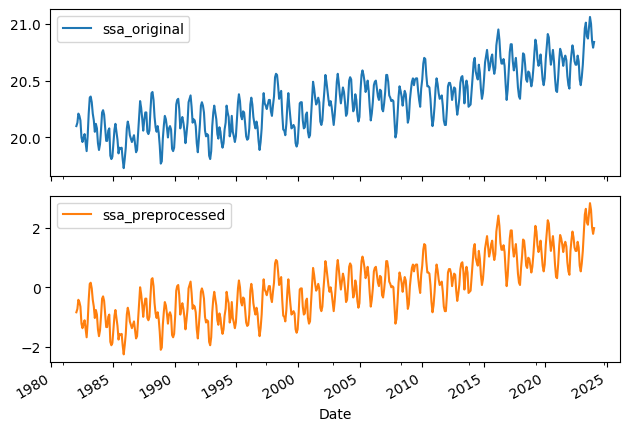

In [11]:
# after initialization
ssa = SSA(sst)
print(ssa.groups)
fig, axes = ssa.plot(kind='timeseries', subplots=True)

{'ssa_original': None, 'ssa_preprocessed': None, 'ssa_reconstructed': None}


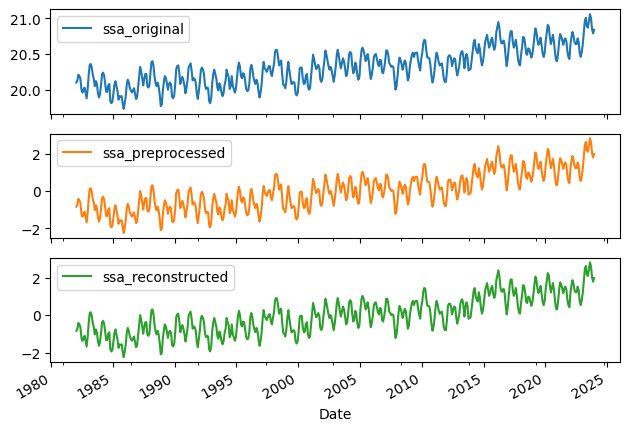

In [12]:
# after decomposition
ssa = SSA(sst).decompose()
print(ssa.groups)
fig, axes = ssa.plot(kind='timeseries', subplots=True)

{'ssa_original': None, 'ssa_preprocessed': None, 'ssa_reconstructed': None, 'ssa_residuals': None, 'Trend': [0, 1], 'Seasonal': [2, 3, 4, 5]}


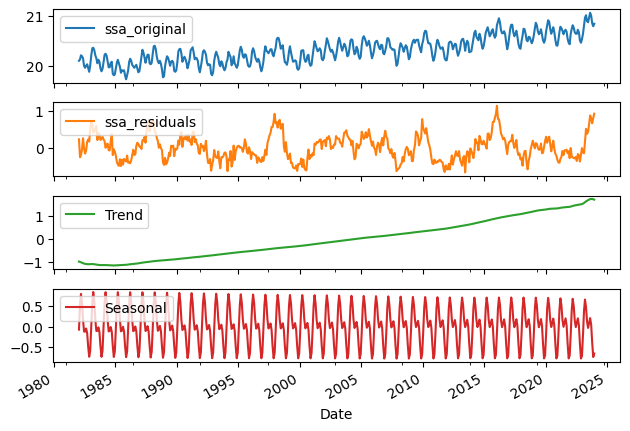

In [13]:
# after
ssa = SSA(sst).decompose().reconstruct(groups={'Trend': [0, 1], 'Seasonal': [2, 3, 4, 5]})
print(ssa.groups)
fig, axes = ssa.plot(
    kind='timeseries',
    exclude=['ssa_preprocessed', 'ssa_reconstructed'],
    subplots=True
)

**Note**

The `SingularSpectrumAnalysis` class has a `__getitem__`` API facilitating access to reconstructed time series. The returned timeseries have the same type as the input time series, either a numpy array or a pandas series. In case of a pandas series, it is then possible to use the pandas plot API.


<Axes: xlabel='Date'>

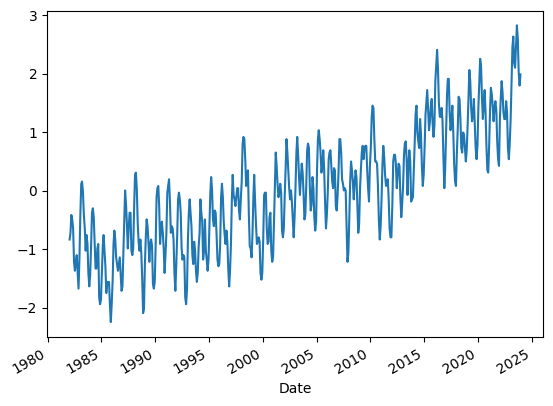

In [14]:
# by name
ssa['ssa_preprocessed'].plot()

<Axes: xlabel='Date'>

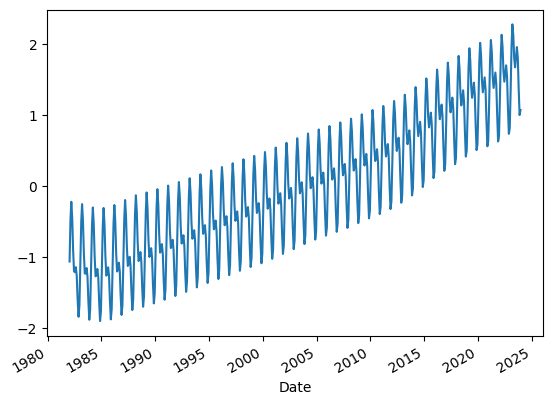

In [15]:
# By indices
ssa[:6].plot()

### Value Plot

_Decomposition required._

Value plot (`kind='values'`) is the default kind while calling the `plot` method. It shows the singular values, ranked by decreasing strength or dominant frequency. For the `MonteCarloSSA` class, the value plot shows the surrogate data projected distribution.

**Kind-Specific Arguments**
- n_components: the maximum number of components to include. Default is 10.
- rank_by: whether to rank by `'values'` (default) or `'freq`.

For `MonteCarloSSA`:
- confidence_level: the confidence level for defining the percentile interval of the surrogate value distribution.
- two_tailed: if True, uses two-tailed confidence intervals, else one-tailed.
- errorbar_kwargs : dictionary to pass arguments to the matplotlib errorbar method.

**Extra Arguments**

- See [`matplotlib.pyplot.plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)
- See [`matplotlib.pyplot.errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) (`MonteCarloSSA`)

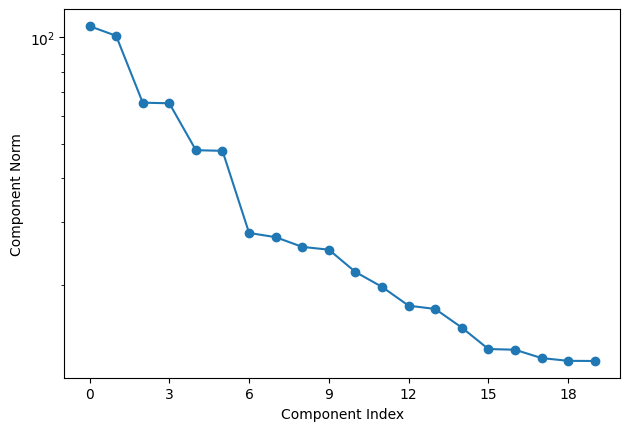

In [16]:
ssa = SSA(sst).decompose()
fig, ax = ssa.plot(n_components=20, marker='o')

**Remarks**
* The main components in the signal are often displaying a decreasing staircase patterns before reaching a more continuous decrease and a noise floor.
* It is common to keep the strongest components for reconstruction...
* However, some structured signal having variance lower or equal to the noisy part could then be overlooked.

In the latter case, `MonteCarloSSA` can be used to indentify low-variance structured signals.

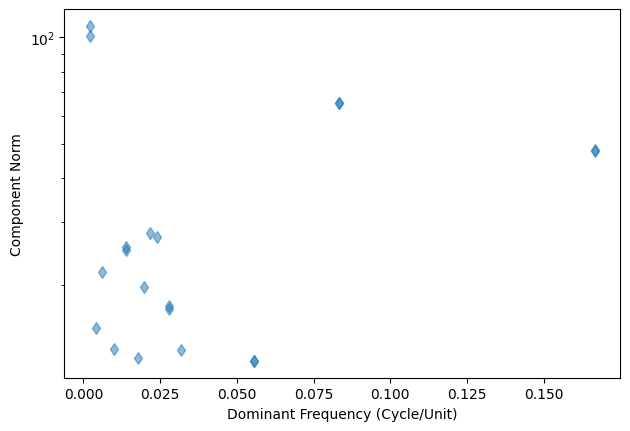

In [17]:
ssa = SSA(sst).decompose()
fig, ax = ssa.plot(
    n_components=20,
    rank_by='freq',
    marker='d', ls='none', alpha=.5
)

**Remarks**
* The two strongest components have frequency close to zero, indicating a trend.
* The next couple of strongest components overlap at frequency ~0.08 (1/12), indicating an annual cycle.
* The next couple of strongest components overlap at ~0.167 (1/6), indicating a semi-annual cycle.

Two singular values with the same norm are often related to the cosine and sine components of signal cycle.

### Vector Plot

_Decomposition required._

Vector plot (`kind='vectors'`) is a collection of subplots showing successive eigenvectors.
Vector plot is used for structured pattern recognition and to hint on the frequency of the reconstructed patterns.
This visualization is inspired from the rSSA package in R [[1]](#ref-1).

The title mentions the percentage contribution of the components in capturing the variance of the SVD matrix.

**Kind-Specific Arguments**
- n_components: the maximum number of components to include. Default is 10.

**Extra Arguments**

- See [`matplotlib.pyplot.plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)

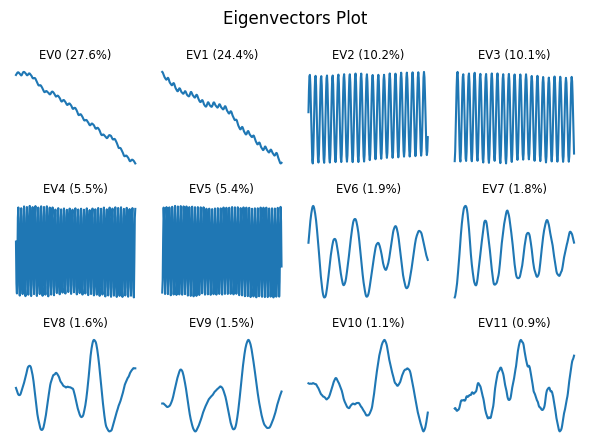

In [18]:
ssa = SSA(sst).decompose()
fig, axes = ssa.plot(kind='vectors')
fig.suptitle('Eigenvectors Plot')
fig.tight_layout()

### Weighted Correlation Plot

_Decomposition required_

The weighted correlation plot (`kind='wcorr'`) shows the dependencies between elementary series. Weighting is applied to correct from the fact that some lagged segments overlap less than others near the boundaries of the series. The weighted correlation plot informs about which components should be grouped together.

**Kind-Specific Arguments**
- n_components: the maximum number of components to include. Default is 10.

**Extra Arguments**

- See [`matplotlib.pyplot.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)

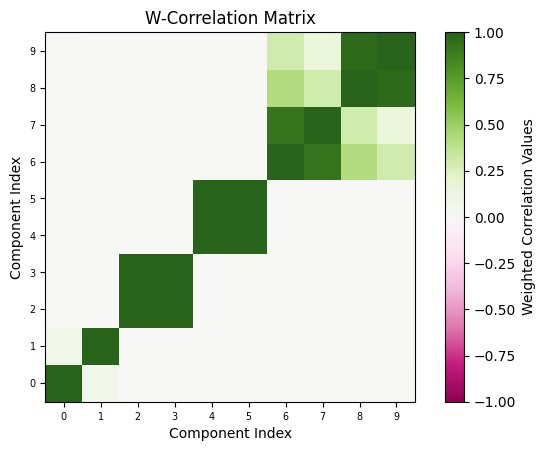

In [19]:
ssa = SSA(sst).decompose()
fig, ax = ssa.plot(kind='wcorr')
_ = ax.set_xlabel('Component Index')
_ = ax.set_ylabel('Component Index')
cbar = ax.collections[0].colorbar
cbar.set_label('Weighted Correlation Values')

## References

1. <span id='ref-1'></span> Korobeynikov, A., Shlemov, A., Usevich, K., & Golyandina, N. (2024). Rssa: A Collection of Methods for Singular Spectrum Analysis (Version 1.1). Retrieved from https://CRAN.R-project.org/package=Rssa
2. <span id='ref-2'></span> Hassani, H. (2007). Singular Spectrum Analysis: Methodology and Comparison. Journal of Data Science, 5(2), 239–257.
   https://doi.org/10.6339/JDS.2007.05(2).396